## Before Starting: Conda environment creation:
- Before starting testing the performance, we need to prepare the appropriate conda environments:
  
  1- tf_PyPI: conda environment with standard Python distribution 3.6 and standard non Intel optimized Tensorflow 1.7.0.
  
  2- tf_intel: conda environment with Intel Python distribution 3.6 and Intel optimized Tensorflow 1.4.0.
  
- for more information about the environment creation, check 
[Conda_env_creation.ipynb](Conda_env_creation.ipynb).

In [1]:
%run Conda_env_creation.ipynb


CondaValueError: prefix already exists: /home/u13849/.conda/envs/tf_PyPI

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Installed kernelspec tf_PyPI in /home/u13849/.local/share/jupyter/kernels/tf_pypi
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

CondaValueError: prefix already exists: /home/u13849/.conda/envs/tf_intel

# conda environments:
#
test_env                 /home/u13849/.conda/envs/test_env
tf_1.6                   /home/u13849/.conda/envs/tf_1.6
tf_PyPI                  /home/u13849/.conda/envs/tf_PyPI
tf_intel                 /home/u13849/.conda/envs/tf_intel
root                  *  /glob/intel-python/versions/2018u2/intelpython3



You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Installed kernelspec tf_intel in /home/u13849/.local/share/jupyter/kernels/tf_intel
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Now we have 2 conda environments ready, we will start with tf_PyPI first
- Note: Steps to switch kernels in jupyter notebook:

    - From the toolbar on top, choose Kernel -> Change Kernel -> choose the kernel you want to switch to.
    - Restart kernal from Kernel-> Restart

<img src="notebook_data/dropdown.png" style='border:2px solid gray'>




## Step 1: 
### Train the human segmentation model inside the conda environment tf_PyPI:
- Standard python distribution
- Standard Tensorflow 1.7.0
- Read input data directly from desk and preprocess data on the fly, using tf.data API
- Batch size = 32
- Data format = NHWC

In [1]:
%%writefile case1.py
#Case(1): standard Python distribution + standard tensorflow + raw_data
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='raw_data')

Overwriting case1.py


In [107]:
%%writefile job1
cd $PBS_O_WORKDIR
source activate tf_PyPI
mkdir results
python case1.py &> results/log1.txt

# need an empty line at the end

Overwriting job1


In [108]:
#Submit the job to the queue
!qsub job1

77892.c009


## How to set-up VTune and start profiling your application

<img src="notebook_data/1-welcome.png" style='border:2px solid gray'>

------------------------------------------------------

<img src="notebook_data/2-createproject.png" style='border:2px solid gray'>

----------------------------------------------------

<img src="notebook_data/3-config-1.png" style='border:2px solid gray'>

-----------------------------------------------------

<img src="notebook_data/4-config-2.png" style='border:2px solid gray'>

------------------------------------------------------

### To get more details about how to get VTune Amplifier and how to start using it visit this link:
[Intel VTune Amplifier](https://software.intel.com/en-us/intel-vtune-amplifier-xe)

-------------

In [109]:
!cat results/log1.txt

2018-05-01 15:05:33.195909: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA


#### Your output result should be close to the following:

- Training time per Epoch: 180.5 sec
- Training time per Epoch: 121.6 sec
- Training time per Epoch: 125.2 sec

## Observation 1:
![Vtune-amplifier results, Bottom-up](notebook_data/case1-bottom-up.png)
---------------------------------------------------------------------------------
---

## Step 2:
### Train our network inside the same conda environment tf_PyPI and apply data serialization:
- Reading data directly from tfrecord using tf.data API

In [6]:
%%writefile case2.py
#Case(2): standard Python distribution + standard tensorflow + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord')

Overwriting case2.py


In [7]:
%%writefile job2
cd $PBS_O_WORKDIR
source activate tf_PyPI
python case2.py &> results/log2.txt

# need an empty line at the end

Overwriting job2


In [8]:
#Submit the job to the queue
!qsub job2

77841.c009


In [32]:
!cat results/log2.txt

2018-05-01 14:05:22.580545: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
/home/u13849/.conda/envs/tf_PyPI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 37.329054 sec
Training time Epoch 1: 34.977451 sec
Training time Epoch 2: 35.019225 sec


#### Your output result should be close to the following:

- Training time per Epoch: 35.5 sec
- Training time per Epoch: 35.2 sec
- Training time per Epoch: 35 sec


## Observation 2:
### VTune Bottom-up
<kdb>![Vtune-amplifier results, Bottom-up](notebook_data/case2-bottom-up.png)</kdb>
--------------------------------------------------------------------------------
---

### APS report
- Low floating-point unit utilization
- 99% of the floating point instructions are 256-bit vector instructions

[![Case(2) APS report](notebook_data/aps-case2.png)](notebook_data/aps-case2.html)
---------------------------------------------------------------------------------

---

## Vector Instructions

![Array Vectorization](notebook_data/array-vectorization.png)
---------------------------------------------------------------
---

## Evolution of Vector Instructions

![Array Vectorization](notebook_data/intel-isa-evolution.png)

-----

## Step 3:
### Now change the conda environment to tf_intel in order to start using Intel optimizations for Python and Tensorflow:
- Intel distribution of Python 3.6
- Intel optimized Tensorflow 1.4.0
- Reading data from tfrecord file
- Data_format = NHWC


In [10]:
%%writefile case3.py
#Case(3): Intel Python distribution + Intel optimized Tensorflow + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord')

Overwriting case3.py


In [11]:
%%writefile job3
cd $PBS_O_WORKDIR
source activate tf_intel
python case3.py &> results/log3.txt

# need an empty line at the end

Overwriting job3


In [12]:
#Submit the job to the queue
!qsub job3

77842.c009


In [92]:
!cat results/log3.txt

2018-05-01 14:05:17.751781: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
/home/u13849/.conda/envs/tf_intel/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 59.335081 sec
Training time Epoch 1: 53.956529 sec
Training time Epoch 2: 56.365599 sec


#### Your output result should be close to the following:

- Training time per Epoch: 56.3 sec
- Training time per Epoch: 55.2 sec
- Training time per Epoch: 55.4 sec

--------------

## Observation 3:

- Now 96.5% of the floating-point instructions are 512-bit vector instructions, but the total FPU is still low
- Sever OpenMP Imbalance 71%
- Number of OpenMP threads are 288
    

[![Case(3) APS report](notebook_data/aps-case3.png)](notebook_data/aps-case3.html)
---------------------------------------------------------------------------------
---

## Inter-op/Intra-op Parallelism

![Inter/Intra](notebook_data/inter-intra.png)

----

## Step 4:
### Now start tuning environment variables based on the guidance of the previous APS report:
- To resolve the high OpenMP imbalance, set the Inter-op-threads=2 (equals to number of sockets) and the Intra-op-threads=12 (equals to number of physical cores, 6 cores/socket)

In [14]:
%%writefile case4.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case4.py


In [15]:
%%writefile job4
cd $PBS_O_WORKDIR
source activate tf_intel
python case4.py &> results/log4.txt

# need an empty line at the end

Overwriting job4


In [16]:
#Submit the job to the queue
!qsub job4

77843.c009


In [30]:
!cat results/log4.txt

2018-05-01 14:05:17.598136: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
/home/u13849/.conda/envs/tf_intel/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 22.500714 sec
Training time Epoch 1: 18.718748 sec
Training time Epoch 2: 18.970582 sec


#### Your output result should be close to the following:

- Training time per Epoch: 19.6 sec
- Training time per Epoch: 18.2 sec
- Training time per Epoch: 18.5 sec

----------


## Observation 4:

- OpenMP imbalance is now better, but we still can improve it more


[![Case(4) APS report](notebook_data/aps-case4.png)](notebook_data/aps-case4.html)
---------------------------------------------------------------------------------
---

## Thread Affinity

Ability to bind OpenMP threads to physical cores

![Affinity](notebook_data/affinity-compact.png)

----


## Step 5:
### More tuning for environment variables to reduce the openMP high imbalance:
- Set KMP_AFFINITY=compact,1,granularity=fine

In [18]:
%%writefile case5.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case5.py


In [19]:
%%writefile job5
cd $PBS_O_WORKDIR
source activate tf_intel
export KMP_AFFINITY=compact,1,granularity=fine
python case5.py &> results/log5.txt

# need an empty line at the end

Overwriting job5


In [20]:
#Submit the job to the queue
!qsub job5

77844.c009


In [29]:
!cat results/log5.txt

2018-05-01 14:05:54.998547: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
/home/u13849/.conda/envs/tf_intel/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 18.873679 sec
Training time Epoch 1: 16.718523 sec
Training time Epoch 2: 16.613143 sec


#### Your output result should be close to the following:

- Training time per Epoch: 17 sec
- Training time per Epoch: 16.51 sec
- Training time per Epoch: 16.3 sec

---

## Observation 5:

- Setting Affinity significantly reduces the openMP imbalance to below the threshold value (10%), but we still have high serial time
- Also FPU increases to be 13 %, but it could be better


[![Case(5) APS report](notebook_data/aps-case5.png)](notebook_data/aps-case5.html)
---------------------------------------------------------------------------------
---

## KMP_BLOCKTIME

Time the thread should wait after execution, before sleeping

![BlockTime](notebook_data/kmp_blocktime.svg.png)

----

## Step 6: 
### Setting KMP_BLOCKTIME to resolve high serial time and low FPU

In [22]:
%%writefile case6.py
#Case(4): Intel Python distribution + Intel optimized Tensorflow whl + tfrecord
from train_model import train_model
model = train_model()
model.train(32, 3, subset='train', source='tfrecord', inter=2, intra=12)

Overwriting case6.py


In [23]:
%%writefile job6
cd $PBS_O_WORKDIR
source activate tf_intel
export KMP_AFFINITY=compact,1,granularity=fine
export KMP_BLOCKTIME=2
python case6.py &> results/log6.txt

# need an empty line at the end

Overwriting job6


In [24]:
#Submit the job to the queue
!qsub job6

77845.c009


In [91]:
!cat results/log6.txt
!qstat

2018-05-01 14:05:28.984153: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
/home/u13849/.conda/envs/tf_intel/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training time Epoch 0: 16.059696 sec
Training time Epoch 1: 13.689779 sec
Training time Epoch 2: 13.624463 sec
Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
77789.c009                 ...ub-singleuser u13849          00:09:23 R jupyterhub     
77833.c009                 job1             u13849          00:21:15 R batch          
77840.c009                 job1             u13849          00:

#### Your output result should be close to the following:

- Training time per Epoch: 14 sec
- Training time per Epoch: 13.75 sec
- Training time per Epoch: 13.74 sec

-----

## Observation 6:
- Now the FPU is 2x better (31%)
- Also the serial time is now less than 10% of the total elapsed time (8.75%)


[![Case(6) APS report](notebook_data/aps-case6.png)](notebook_data/aps-case6.html)
---------------------------------------------------------------------------------

## Summary
- The following chart is showing the performance improvement for all previous cases

![All cases](notebook_data/chart-1-c009.png)

- This is the final result
![All cases](notebook_data/chart-2-c009.png)

-----

## More about Tensorflow Optimizations for Intel architecture

[TensorFlow* Optimizations for the Intel® Xeon® Scalable Processor](https://ai.intel.com/tensorflow-optimizations-intel-xeon-scalable-processor/#_ftn3)


[Intel Optimized TensorFlow* Installation Guide](https://software.intel.com/articles/intel-optimized-tensorflow-installation-guide)


[TensorFlow* Optimizations on Modern Intel® Architecture](https://software.intel.com/en-us/articles/tensorflow-optimizations-on-modern-intel-architecture)

[TensorFlow Performance Guide](https://www.tensorflow.org/performance/performance_guide)


-----


## Human Segmentation After Optimization
Now, after using VTune Amplifier and APS guidance to optimize our model, human segmentation model is trained for 1000 epochs and ready for inference.

To test the trained model using the validation dataset, run the next cell.

INFO:tensorflow:Restoring parameters from weights/NHWC_train_hs_val_1000.ckpt


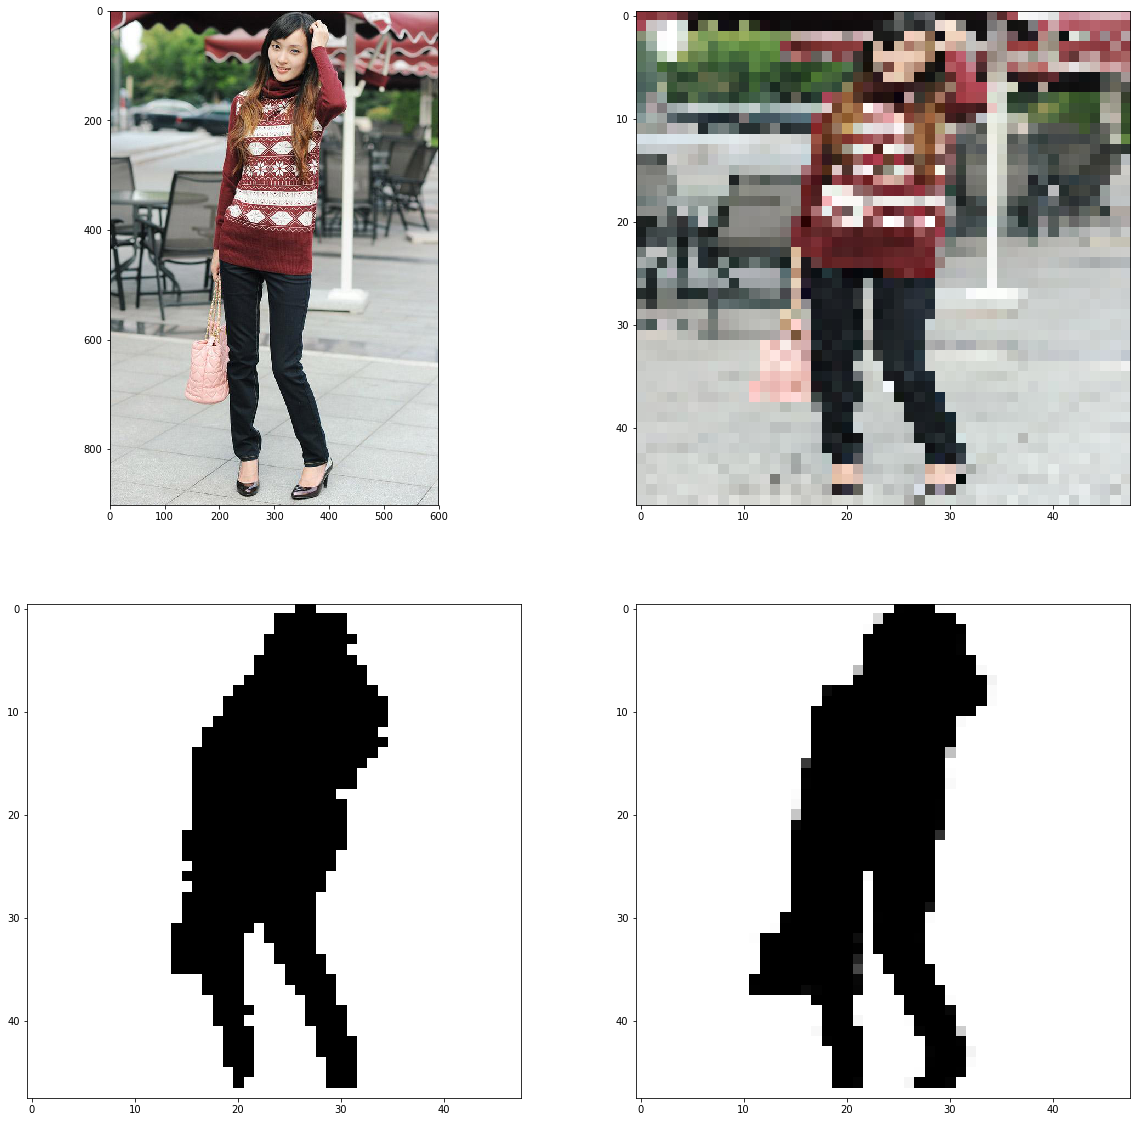

In [5]:
from inference import visualize
visualize("validate_dataset")

Displayed images are:
- Top left: original image
- Top right: original image resized (48, 48, 3)
- Bottom left: model output (48, 48)
- Bottom right: ground truth resized (48, 48)

## Try your own image
Why don't you try your own image now?
All what it needs is a person's image, it would provide better results if the image is of the following specs:

- Person standing with full length in the mid of the image
- Single person in the image
- Contrast exists between the background and the person in the image

Check the following image to have some idea about how should the image looks like:

<img src="notebook_data/example-image-2.jpg" width="200"  >

## Steps to try the human segmentation model by yourself:

- Upload an image with the previous specs
- place it in the same directory as the notebook 
- rename the image to "input-image.jpg"
- Run the next cell

INFO:tensorflow:Restoring parameters from weights/NHWC_train_hs_val_1000.ckpt


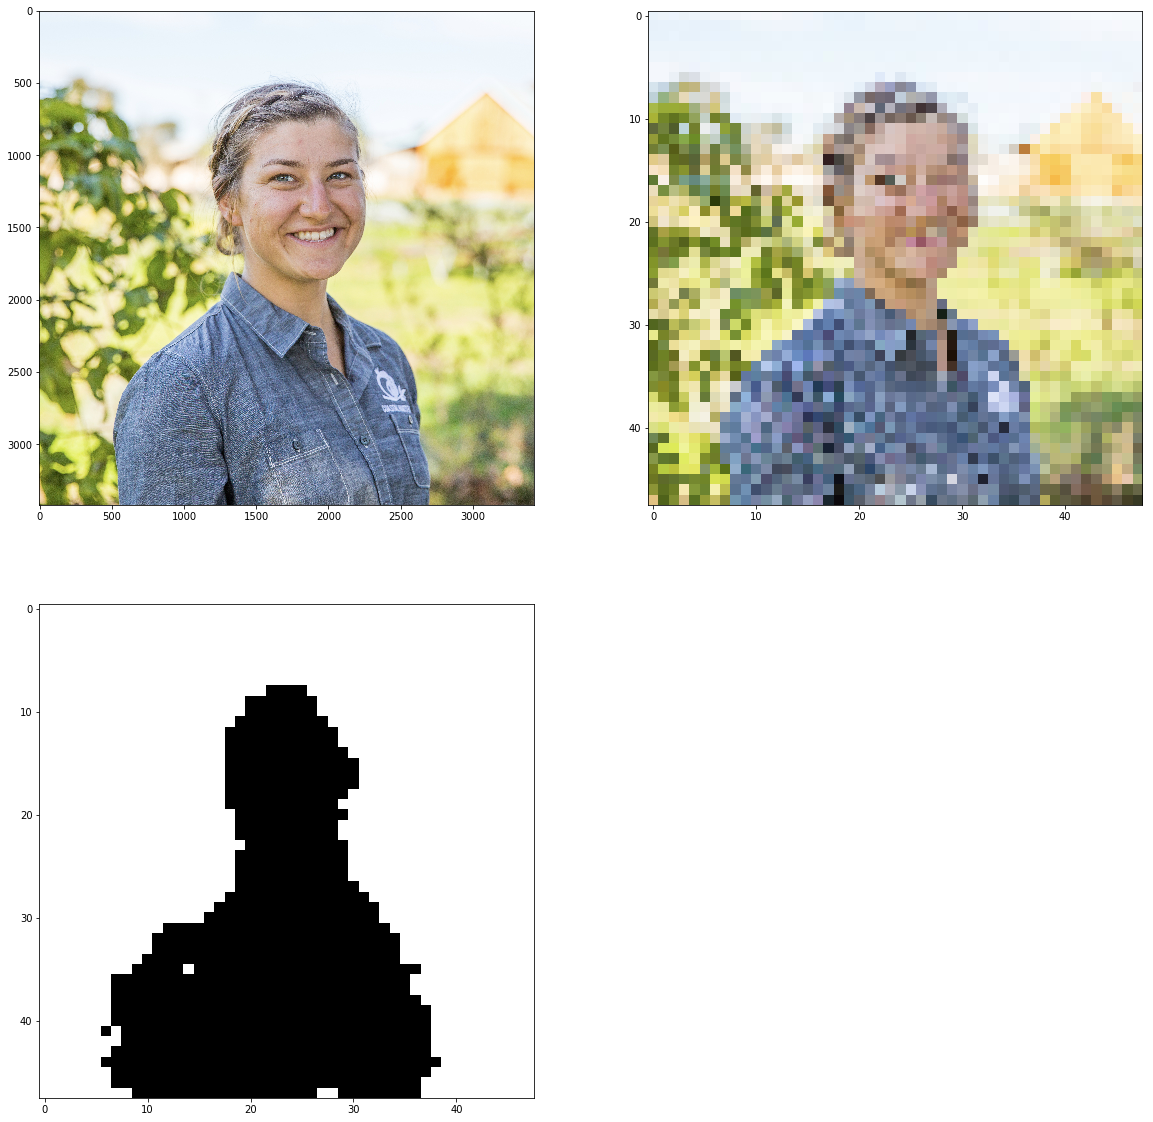

In [3]:
from inference import visualize
visualize("uploaded_image")